In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys

# Data Description

- read_name - "The original read name"
- read_length - "The length of the read in bases"
- read_idx - "Unique integer ID of the read"
- contact_is_direct - "There are no intervening assigned restriction fragments on the read"
- contact_is_cis - "Both alignments come from the same chromsome/contig"
- contact_read_distance - "The distance between the end of the left alignment and the start of the right alignment on the read"
- contact_genome_distance - "The distance between the end of the left alignment and the start of the right alignment (valid for cis contacts only)"
- contact_fragment_adjacent - "A boolean to indicate if the contact is between the same or adjacent fragments"
- contact_fragment_distance - "The distance between the midpoints of the assigned fragments (valid for cis contacts only)"
- haplotype_pair_type - "A categorical variable describing the relationship between the haplotypes assigned to each of the alignments in a contact"
- align1_align_idx - "Unique integer ID of the first aligned segment"
- align1_chrom - "The chromosome/contig of the first aligned segment"
- align1_start - "The zero-based start position on the genome of the alignment"
- align1_end - "The end position on the genome of the alignment"
- align1_strand - "The alignment strand"
- align1_mapping_quality - "The mapping quality as calculated by the aligner"
- align1_align_score - "The alignment score as calculated by the aligner"
- align1_align_base_qscore - "The mean read base score for the aligned segment (rounded to the nearest integer)."
- align1_phase_set - "The ID of the phase set, often this is the start position of the phase block"
- align1_phase_qual - "The phred-scaled quality score of the haplotype assignment"
- align1_haplotype - "The id of the haplotype within this block, usually set to 1 or 2. A value of -1 means that this alignment is unphased"
- align1_fragment_id - "The UID of the restriction fragment assigned to this alignment"
- align1_fragment_start - "The start point on the genome of this restriction fragment"
- align1_fragment_end - "The end point on the genome of this restriction fragment"
- align2_align_idx - "Unique integer ID of the first aligned segment"
- align2_chrom - "The chromosome/contig of the first aligned segment"
- align2_start - "The zero-based start position on the genome of the alignment"
- align2_end - "The end position on the genome of the alignment"
- align2_strand - "The alignment strand"
- align2_mapping_quality - The mapping quality as calculated by the aligner"
- align2_align_score - "The alignment score as calculated by the aligner",
- align2_align_base_qscore= - "The mean read base score for the aligned segment (rounded to the nearest integer)."
- align2_phase_set - "The ID of the phase set, often this is the start position of the phase block"
- align2_phase_qual - "The phred-scaled quality score of the haplotype assignment"
- align2_haplotype - "The id of the haplotype within this block, usually set to 1 or 2. A value of -1 means that this alignment is unphased"
- align2_fragment_id - "The UID of the restriction fragment assigned to this alignment"
- align2_fragment_start - "The start point on the genome of this restriction fragment"
- align2_fragment_end - "The end point on the genome of this restriction fragment"


In [2]:
# dirpath = "/nfs/turbo/umms-indikar/shared/tools/Pore-C-Snakemake/results_ES_Cells_2021/contacts/"
dirpath = "/nfs/turbo/umms-indikar/shared/tools/Pore-C-Snakemake/results_ES5to12/contacts/"

cell = "NlaIII_run07"

df_list = []
for f in os.listdir(dirpath):
    if cell in f:
        filepath = f"{dirpath}{f}"
        tmp = pd.read_parquet(filepath)
        tmp['batch_id'] = f.split("_")[2]
        
        df_list.append(tmp)
        
        
df = pd.concat(df_list)
print(f"{df.shape=}")
df.head()

df.shape=(10525887, 38)


,read_name,read_length,read_idx,contact_is_direct,contact_is_cis,contact_read_distance,contact_genome_distance,contact_fragment_adjacent,contact_fragment_distance,haplotype_pair_type,...,align2_strand,align2_mapping_quality,align2_align_score,align2_align_base_qscore,align2_phase_set,align2_haplotype,align2_fragment_id,align2_fragment_start,align2_fragment_end,batch_id
0,000188c4-51f3-4a10-9bce-f328c3594118,849,22724,True,True,13,-2205,True,0,unphased,...,True,38,216,14,0,-1,7450888,34492235,34499305,batch15
1,000188c4-51f3-4a10-9bce-f328c3594118,849,22724,False,True,199,18,True,0,unphased,...,True,121,166,13,0,-1,7450888,34492235,34499305,batch15
2,000188c4-51f3-4a10-9bce-f328c3594118,849,22724,False,True,432,-856,True,0,unphased,...,True,14,86,22,0,-1,7450888,34492235,34499305,batch15
3,000188c4-51f3-4a10-9bce-f328c3594118,849,22724,True,True,-58,1978,True,0,unphased,...,True,121,166,13,0,-1,7450888,34492235,34499305,batch15
4,000188c4-51f3-4a10-9bce-f328c3594118,849,22724,False,True,175,1104,True,0,unphased,...,True,14,86,22,0,-1,7450888,34492235,34499305,batch15


In [3]:
# print unfiltered cis/trans ratio
def printCisTransRatio(df):
    cisContacts = np.sum(np.where(df['contact_is_cis'] == 1, 1, 0))
    transContacts = np.sum(np.where(df['contact_is_cis'] == 0, 1, 0))

    
    print(f"{cisContacts=}")
    print(f"{transContacts=}")
    print(f"{cisContacts/transContacts=:.4f}")
    
printCisTransRatio(df)

cisContacts=7456892
transContacts=3068995
cisContacts/transContacts=2.4298


In [4]:
# Nanago et. state that .99 of reads mapped to cut sites exactly

align1CutSiteMatch = np.where(df['align1_end'] == df['align1_fragment_end'], 1, 0)
align2CutSiteMatch = np.where(df['align2_end'] == df['align2_fragment_end'], 1, 0)

cutSiteMatches = list(align1CutSiteMatch) + list(align2CutSiteMatch)

exact = np.sum(cutSiteMatches)
n = len(cutSiteMatches)

print(f"{exact=}")
print(f"{n=}")
print(f"{exact/n=:.3f}")

exact=1552217
n=21051774
exact/n=0.074


Text(0, 0.5, 'Number of Contacts')

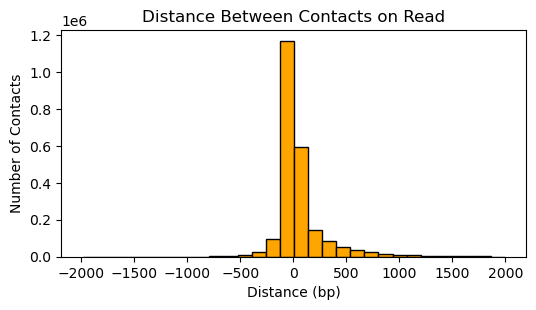

In [5]:
# look at distribution of distances between fragments on read

plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = 6, 3


tmp = df[df['contact_is_direct'] == True]

lb = -2000
ub = 2000

tmp = tmp[(tmp['contact_read_distance'] >= lb) & (tmp['contact_read_distance'] <= ub) ]

plt.hist(tmp['contact_read_distance'], edgecolor='k', bins=30, color='orange')


plt.title('Distance Between Contacts on Read')
plt.xlabel('Distance (bp)')
plt.ylabel('Number of Contacts')



In [6]:
assembly = pd.read_csv("GRCm39_Assembly.txt")
assembly

,Chromosome,Total length,GenBank accession,RefSeq accession
0,1,195154279,CM000994.3,NC_000067.7
1,2,181755017,CM000995.3,NC_000068.8
2,3,159745316,CM000996.3,NC_000069.7
3,4,156860686,CM000997.3,NC_000070.7
4,5,151758149,CM000998.3,NC_000071.7
5,6,149588044,CM000999.3,NC_000072.7
6,7,144995196,CM001000.3,NC_000073.7
7,8,130127694,CM001001.3,NC_000074.7
8,9,124359700,CM001002.3,NC_000075.7
9,10,130530862,CM001003.3,NC_000076.7


In [7]:
"""
NOTE: there is no sort order between align1 and align2 and fragments can be in either column
"""

# g = []

# for frag in df['align1_fragment_id']:
#     if frag in df['align2_fragment_id']:
#         g.append(1)
#     else:
#         g.append(0)
        
# np.sum(g) / len(g)

'\nNOTE: there is no sort order between align1 and align2 and fragments can be in either column\n'

# Contact Filters

In [8]:
# mapping quality filter

def mapQFilter(df, mapQ=30):
    mask = (df['align1_mapping_quality'] >= mapQ) & (df['align2_mapping_quality'] >= mapQ)
    df = df[mask].reset_index(drop=True)
    return df
    
    
print(f"{df.shape=}")
df = mapQFilter(df)
print(f"{df.shape=}")

df.shape=(10525887, 38)
df.shape=(4695701, 38)


In [9]:
# a filter for direct contacts too far away on the read

def distalContactFilter(df, read_distance=1000):
    
    mask = (np.abs(df['contact_read_distance']) <= read_distance) & (df['contact_is_direct'] == True)
    df = df[mask].reset_index(drop=True)
    return df

print(f"{df.shape=}")
df = distalContactFilter(df)
print(f"{df.shape=}")

df.shape=(4695701, 38)
df.shape=(1079980, 38)


In [10]:
# contacts within 1kb ON THE REFERENCE are assumed to be amplification bias

def closeContactFilter(df, genome_distance=1000):
    """cis contacts only """
    mask = (np.abs(df['contact_genome_distance']) >= genome_distance)
    df = df[mask].reset_index(drop=True)
    return df


print(f"{df.shape=}")
df = closeContactFilter(df)
print(f"{df.shape=}")

df.shape=(1079980, 38)
df.shape=(373554, 38)


In [11]:
# filter duplicate contacts: does this make sense? the contact with the higest average MAPQ is retained

def duplicateContactFilter(df, retain=1):
    # retain == 1 is unique contacts

    df['mean_mapping_quality'] = (df['align1_mapping_quality'] + df['align2_mapping_quality']) / 2
    
    df = df.sort_values(by=['align1_fragment_id', 
                            'align2_fragment_id', 
                            'mean_mapping_quality'], ascending=False)
    
    df['contact_count'] = df.groupby(["align1_fragment_id", "align2_fragment_id"])["read_name"].transform("cumcount")
    df['contact_count'] = df['contact_count'] + 1

    mask = (df['contact_count'] <= retain)
    df = df[mask]
    return df
    

print(f"{df.shape=}")
df = duplicateContactFilter(df, retain=1)
print(f"{df.shape=}")

df.shape=(373554, 38)
df.shape=(99979, 40)


In [12]:
# for single cells, there can be at most 2 copies of any sequence (ligation product)

def getFragmentCounts(df):
    allFragments = df['align1_fragment_id'].tolist() + df['align2_fragment_id'].tolist()
    return Counter(allFragments)
    

def ligationProductFilter(df, nProducts=2, verbose=True):
    
    # get fragment counts
    countTranslation = dict(getFragmentCounts(df))

    df['align1_fragcount'] = df['align1_fragment_id'].map(countTranslation)
    df['align2_fragcount'] = df['align2_fragment_id'].map(countTranslation)

    mask = (df['align1_fragcount'] <= nProducts) & (df['align2_fragcount'] <= nProducts)

    # divide into contacts with less than n replicates and more than n replicates
    lowFrequencyProducts = df[mask].reset_index()
    amplificationBiasProducts = df[~mask].reset_index()
    
    # count the number of unique reads per fragment
    readsPerFragment1 = amplificationBiasProducts[['read_name', 'align1_fragment_id']]
    readsPerFragment2 = amplificationBiasProducts[['read_name', 'align2_fragment_id']]
    
    readsPerFragment1.columns = ['read_name', 'fragment_id']
    readsPerFragment2.columns = ['read_name', 'fragment_id']

    readsPerFragment = pd.concat([readsPerFragment1, readsPerFragment2], ignore_index=True)
    
    if verbose:
        print(f"{lowFrequencyProducts.shape=} ({len(lowFrequencyProducts)/len(df):.3f})")
        print(f"{amplificationBiasProducts.shape=} ({len(amplificationBiasProducts)/len(df):.3f})")

        print(f"{readsPerFragment1.shape=}")
        print(f"{readsPerFragment2.shape=}")
        print(f"{readsPerFragment.shape=}")
    
    readsPerFragment['n_reads'] = readsPerFragment.groupby('fragment_id')["read_name"].transform('nunique')
    readsPerFragmentMappable = readsPerFragment[['fragment_id', 'n_reads']].to_dict()
    
    # map the number of reads an individual fragment appears in
    amplificationBiasProducts['align_1_n_reads'] = amplificationBiasProducts['align1_fragment_id'].map(readsPerFragmentMappable)
    amplificationBiasProducts['align_2_n_reads'] = amplificationBiasProducts['align2_fragment_id'].map(readsPerFragmentMappable)
    
    # throw away all contacts which appear in more than n reads 
    mask = (amplificationBiasProducts['align_1_n_reads'] <= nProducts) & (amplificationBiasProducts['align_2_n_reads'] <= nProducts)
    
    toKeep = amplificationBiasProducts[mask].reset_index()
    trash = amplificationBiasProducts[~mask].reset_index()
    
    if verbose:
            print(f"{toKeep.shape=}")
            print(f"{trash.shape=}")
    
    df = pd.concat([lowFrequencyProducts, toKeep])
    
    return df
    

    
print(f"{df.shape=}")
df = ligationProductFilter(df)
print(f"{df.shape=}")

testCounts = getFragmentCounts(df)
print(f"{testCounts.most_common(1)=}")


df.shape=(99979, 40)
lowFrequencyProducts.shape=(33376, 43) (0.334)
amplificationBiasProducts.shape=(66603, 43) (0.666)
readsPerFragment1.shape=(66603, 2)
readsPerFragment2.shape=(66603, 2)
readsPerFragment.shape=(133206, 2)
np.sum(~mask)=66603
df.shape=(33376, 46)
testCounts.most_common(1)=[(12876543, 2)]


In [13]:
break

# Chromosome Selection

In [14]:
# subset the data to a single chromosome
chomosome = 2
chrom_assembly = assembly.loc[assembly['Chromosome'] == str(chomosome)]
refseq = chrom_assembly['RefSeq accession'].tolist()[0].strip()

def filterChomosome(df, refseq):
    mask = (df['align1_chrom'] == refseq) & (df['align2_chrom'] == refseq)
    df = df[mask].reset_index(drop=True)
    return df
    
    
chr2 = filterChomosome(df, refseq)
print(f"{chr2.shape=}")

chr2.shape=(2733, 46)


# Added Features

In [15]:
# add the cardinality of the hyperedge
chr2['edgeOrder'] = chr2.groupby(["read_name"])["align2_fragment_id"].transform("count")

# Binning

In [16]:
chrom_length = chrom_assembly['Total length'].tolist()[0]
# scale = 100000 #100kb scale
scale = 1000000 # 1mb scale


def getBins(chrom_length, scale):
    n = int(np.ceil(chrom_length / scale))    
    bins = [scale]
    
    for i in range(n-1):
        next_bin = bins[i] + scale
        bins.append(next_bin)
        
    return np.array(bins)


def returnBin(position, bins):
    idx = np.min(np.argwhere(bins > position))
    return idx - 1 


def binData(df, bins):
    df['align1_bin'] = df['align1_fragment_start'].apply(lambda x: returnBin(x, bins))
    df['align2_bin'] = df['align2_fragment_start'].apply(lambda x: returnBin(x, bins))
    return df
    

bins = getBins(chrom_length, scale)
print(f"{len(bins)=}")


chr21mb = binData(chr2, bins)
print(f"{chr21mb['align1_bin'].min()=}")
print(f"{chr21mb['align1_bin'].max()=}")

print(f"{chr21mb['align2_bin'].min()=}")
print(f"{chr21mb['align2_bin'].max()=}")
    

len(bins)=182
chr21mb['align1_bin'].min()=2
chr21mb['align1_bin'].max()=180
chr21mb['align2_bin'].min()=2
chr21mb['align2_bin'].max()=180


# Construct pseudo Hi-C Matrices

In [17]:
def constructHiC(df, bins, binary=False):
    A = np.zeros((len(bins), len(bins)))
    
    for ind, row in df.iterrows():
        i = row['align1_bin']
        j = row['align2_bin']
        A[i, j] = A[i, j] + 1
        A[j, i] = A[j, i] + 1
        
    if binary:
        A = np.where(A > 0, 1, 0)
    return A

A = constructHiC(chr2, bins, binary=False)
print(f"{A.shape=}")

np.argsort(np.sum(A, axis=0))
    

A.shape=(182, 182)


array([  0, 175, 181,   1, 179, 174, 180, 122, 162, 156, 170, 152, 158,
        68, 176, 164, 177, 110, 159, 165,  32,  98, 161,  25,  92, 172,
       167, 115, 178,  94, 157, 173,  31, 154, 171, 100, 134,  30,  91,
       136, 123,  45, 155,  70, 101,  61, 135, 105, 168, 129,  71,  96,
       132, 116,  53, 166,  69,  95, 153,  26,  52,  24,  48, 141,  97,
        74,  17,   4,  77,  13,  85,   8,  43,  60,  87, 102, 117,  93,
       118, 108,  84, 151,  44,  66,  34,  42, 126,  58,  29,  51,  15,
       149,  11,  62,  65,  99, 146, 107, 133, 169,  23, 106, 148,  27,
         2,  63, 131,   3,  18,  41, 147,   9, 119, 143,  14,  76,  10,
       113,  78,  46, 160,  39,  21, 145,  40,  54,  49,  73,  28,  89,
        82,   6,  67, 120,  33,  88, 150, 109,  16,  80,  47,  86,   5,
        57,  64, 163,  22,  72,  37, 114, 104, 142,  35,  59, 138,  12,
       124,  20, 111, 127, 103, 144,  50,  83,  90, 125, 137,  19, 121,
         7, 130,  75,  56, 112,  36,  38, 140,  81, 128, 139,  7

In [18]:
testBin = chr2[(chr2['align1_bin'] == 169) | (chr2['align2_bin'] == 169) ]

allFragments = testBin['align1_fragment_id'].tolist() + testBin['align2_fragment_id'].tolist()

counts = Counter(allFragments)

counts.most_common(5)

# testBin['contact_count'] = testBin.groupby('read_name')['align2_fragment_start'].transform('count')
# testBin['contact_count'].hist()


[(1755478, 2), (1755120, 2), (1754929, 2), (1754731, 2), (1754601, 2)]

# Plottting

In [19]:
# plt.rcParams['figure.dpi'] = 100
# sns.heatmap(np.log(A))
# plt.gca().set_aspect('equal', adjustable='box')

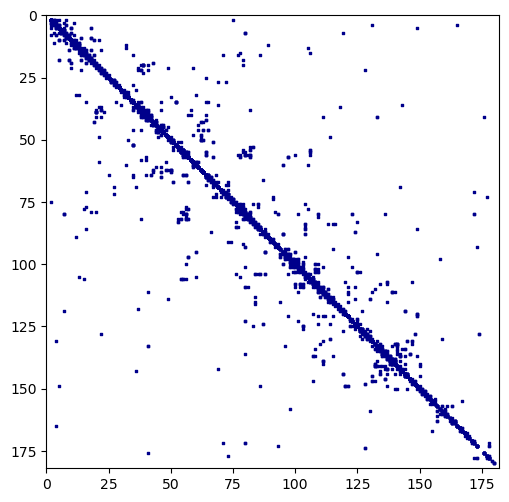

In [20]:
def plotHiCscatter(df, params):
    
    plt.rcParams['figure.dpi'] = params['figdpi']
    plt.rcParams['figure.figsize'] = params['figsize']

    
    plt.scatter(df['align2_bin'], df['align1_bin'], 
                marker='s', 
                s=params['size'], 
                alpha=params['alpha'], 
                c=params['color'])


    plt.scatter(df['align1_bin'], 
                df['align2_bin'], 
                marker='s', 
                s=params['size'], 
                alpha=params['alpha'], 
                c=params['color'])

    plt.xlim(0, len(bins))
    plt.ylim(len(bins), 0)
    ax = plt.gca() # Get current axes object
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    plt.gca().set_aspect('equal', adjustable='box')

    
params = {
    'figdpi' : 100,
    'figsize' : (6,6),
    'size' : 1,
    'alpha' : 1,
#     'color' : np.log(df['edgeOrder']),
    'color' : 'darkblue',
}

# plt.set_cmap('gnuplot_r')
plotHiCscatter(chr2, params)


# clb = plt.colorbar(fraction=0.046, pad=0.04, ticks=[np.min(np.log(df['edgeOrder'])), np.max(np.log(df['edgeOrder']))])
# clb.ax.set_yticklabels(['low', 'high'])
# clb.ax.set_title('Contact Order',fontsize=8)